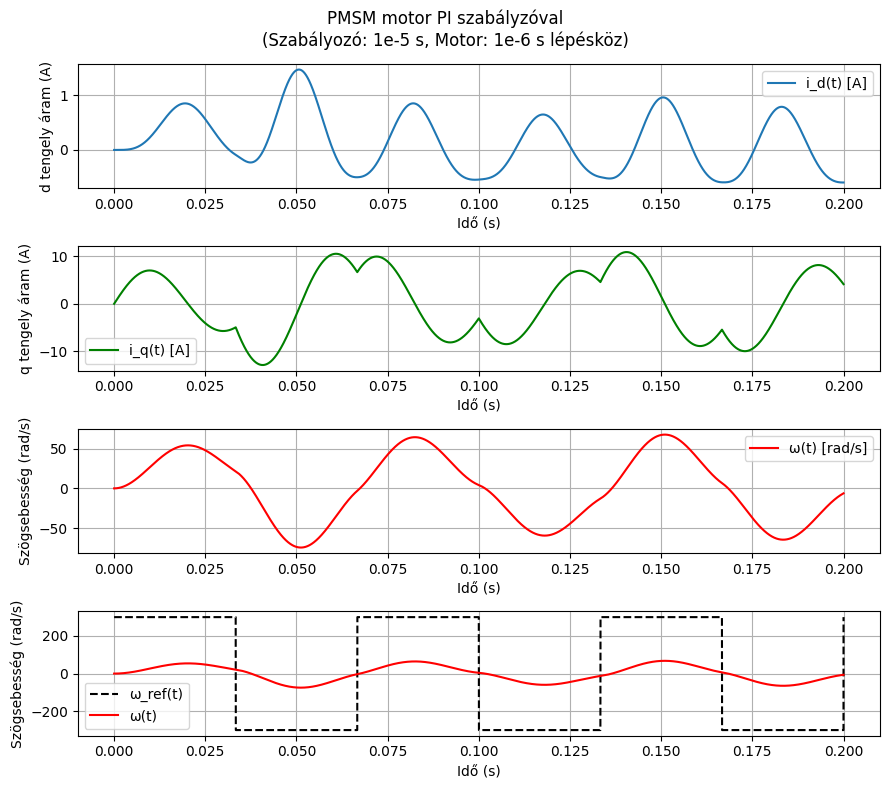

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """Egyszerű szaturációs függvény."""
    return max(vmin, min(value, vmax))

class PMSMSquareWaveRefPIControl:
    """
    PMSM motor PI szabályozóval, ahol a referencia jel (w_ref)
    négyszögjelként változik a self.w_high, self.w_low és self.freq alapján.
    """
    def __init__(self,
                 Rs=0.2,          # Stator ellenállás [ohm]
                 Ld=0.001,       # d tengely induktivitás [H]
                 Lq=0.001,       # q tengely induktivitás [H]
                 lambda_pm=0.1,  # Állandó mágneses fluxus [Wb]
                 J=0.0001,      # Tehetetlenségi nyomaték [kg*m^2]
                 B=0.0,          # Viszkózus súrlódás [N*m*s/rad]
                 P=4,            # Póluspárok száma
                 T_load=0.0,     # Terhelő nyomaték [Nm]
                 Kp=0.5,         # P-szabályozó erősítés
                 Ki=0.1,         # I-szabályozó erősítés
                 w_high=300.0,   # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=-300.0,   # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=5,         # Négyszög-frekvencia [Hz]
                 Vmax=12.0):     # Feszültség szaturáció ± [V]
        self.Rs = Rs
        self.Ld = Ld
        self.Lq = Lq
        self.lambda_pm = lambda_pm
        self.J = J
        self.B = B
        self.P = P
        self.T_load = T_load
        self.Kp = Kp
        self.Ki = Ki
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        Félperiódusonként self.w_high vagy self.w_low.
        """
        T = 1.0 / self.freq
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def simulate(self, x0=None, t_max=0.2, dt_controller=1e-2, dt_motor=1e-6):
        """
        Szimuláció a t = 0 .. t_max időintervallumon.
        
        x0: kezdeti állapot [i_d, i_q, omega_m, e_int] (d és q tengelyen áram, szögsebesség, integrált hiba)
        dt_controller: a PI szabályozó időköze (0.01 s)
        dt_motor: a motor integrációs időlépés (1e-6 s)
        """
        if x0 is None:
            x0 = [0.0, 0.0, 0.0, 0.0]  # [i_d, i_q, omega_m, e_int]
        
        t = 0.0
        times = [t]
        id_vals = [x0[0]]
        iq_vals = [x0[1]]
        omega_vals = [x0[2]]
        e_int_vals = [x0[3]]
        
        x = x0.copy()
        while t < t_max:
            current_time = t
            # Számoljuk ki a referencia jelet a controller frissítés idején
            w_r = self.w_ref(current_time)
            # Hibaszámítás: referencia - aktuális szögsebesség
            error = w_r - x[2]
            # PI szabályozás: u_q = Kp * error + Ki * integrált hiba
            u_q_raw = self.Kp * error + self.Ki * x[3]
            u_q = clamp(u_q_raw, -self.Vmax, self.Vmax)
            u_d = 0  # Általában u_d = 0, ha nincs d tengelyen szabályozás
            
            # A PI szabályozó kimenete állandó a következő dt_controller időszak alatt
            steps = int(dt_controller / dt_motor)
            for _ in range(steps):
                i_d, i_q, omega_m, e_int = x
                # Elektromos dinamika
                omega_e = self.P * omega_m
                di_dt_d = (u_d - self.Rs * i_d + omega_e * self.Lq * i_q) / self.Ld
                di_dt_q = (u_q - self.Rs * i_q - omega_e * self.Ld * i_d - omega_e * self.lambda_pm) / self.Lq
                # Mechanikai dinamika
                T_e = (3/2) * self.P * (self.lambda_pm * i_q + (self.Ld - self.Lq) * i_d * i_q)
                domega_dt = (T_e - self.T_load - self.B * omega_m) / self.J
                # Az integrált hiba deriváltja: hiba (itt a controller frissítéskor számolt)
                de_int_dt = error
                
                # Euler integráció a motor állapotára
                i_d += di_dt_d * dt_motor
                i_q += di_dt_q * dt_motor
                omega_m += domega_dt * dt_motor
                e_int += de_int_dt * dt_motor
                t += dt_motor
                
            x = [i_d, i_q, omega_m, e_int]
            times.append(t)
            id_vals.append(i_d)
            iq_vals.append(i_q)
            omega_vals.append(omega_m)
            e_int_vals.append(e_int)
            
        return np.array(times), np.array(id_vals), np.array(iq_vals), np.array(omega_vals), np.array(e_int_vals)

if __name__ == "__main__":
    motor = PMSMSquareWaveRefPIControl(
        Rs=0.2,
        Ld=0.001,
        Lq=0.001,
        lambda_pm=0.1,
        J=0.0001,
        B=0.0,
        P=4,
        T_load=0.0,
        Kp=0.5,
        Ki=0.1,
        w_high=300.0,
        w_low=-300.0,
        freq=15,
        Vmax=12.0
    )

    # Szimuláció: 0.2 másodperc, controller 1e-5 s-es, motor 1e-6 s-es lépésközzel
    t_max = 0.2
    dt_controller = 1e-5
    dt_motor = 1e-6
    times, id_vals, iq_vals, omega_vals, e_int_vals = motor.simulate(t_max=t_max, dt_controller=dt_controller, dt_motor=dt_motor)
    
    # Ábrázolás
    plt.figure(figsize=(9,8))
    
    plt.subplot(4,1,1)
    plt.plot(times, id_vals, label="i_d(t) [A]")
    plt.xlabel("Idő (s)")
    plt.ylabel("d tengely áram (A)")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(4,1,2)
    plt.plot(times, iq_vals, 'g', label="i_q(t) [A]")
    plt.xlabel("Idő (s)")
    plt.ylabel("q tengely áram (A)")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(4,1,3)
    plt.plot(times, omega_vals, 'r', label="ω(t) [rad/s]")
    plt.xlabel("Idő (s)")
    plt.ylabel("Szögsebesség (rad/s)")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(4,1,4)
    w_ref_vals = np.array([motor.w_ref(t) for t in times])
    plt.plot(times, w_ref_vals, 'k--', label="ω_ref(t)")
    plt.plot(times, omega_vals, 'r', label="ω(t)")
    plt.xlabel("Idő (s)")
    plt.ylabel("Szögsebesség (rad/s)")
    plt.grid(True)
    plt.legend()
    
    plt.suptitle("PMSM motor PI szabályzóval\n(Szabályozó: 1e-5 s, Motor: 1e-6 s lépésköz)")
    plt.tight_layout()
    plt.show()

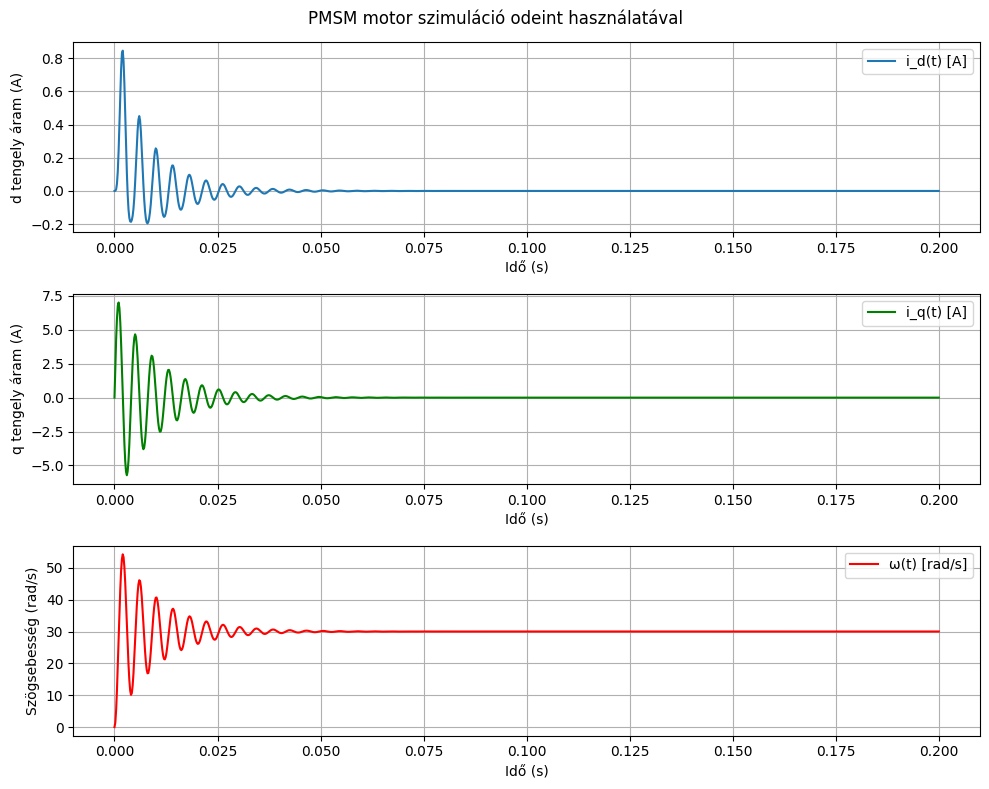

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# PMSM motor paraméterek
Rs = 0.2       # Stator ellenállás [ohm]
Ld = 0.001     # d tengely induktivitás [H]
Lq = 0.001     # q tengely induktivitás [H]
lambda_pm = 0.1  # Állandó mágneses fluxus [Wb]
J = 0.0001     # Tehetetlenségi nyomaték [kg*m^2]
B = 0.0        # Viszkózus súrlódási együttható [N*m*s/rad]
P = 4          # Póluspárok száma
T_load = 0.0   # Terhelő nyomaték [Nm]
Vd = 0.0       # d tengely feszültség [V]
Vq = 12.0      # q tengely feszültség [V]

# Kezdeti állapotok: [i_d, i_q, omega_m]
x0 = [0.0, 0.0, 0.0]

# Időtartomány: 0-tól 0.2 másodpercig, 1000 pontban
t = np.linspace(0, 0.2, 1000)

# Differenciálegyenlet rendszer
def pmsm_model(x, t):
    id, iq, omega_m = x
    omega_e = P * omega_m  # Elektromos szögsebesség

    # d-q tengely egyenletek
    did_dt = (Vd - Rs * id + omega_e * Lq * iq) / Ld
    diq_dt = (Vq - Rs * iq - omega_e * Ld * id - omega_e * lambda_pm) / Lq

    # Elektromágneses nyomaték
    Te = (3/2) * P * (lambda_pm * iq + (Ld - Lq) * id * iq)

    # Mechanikai egyenlet
    domega_dt = (Te - T_load - B * omega_m) / J

    return [did_dt, diq_dt, domega_dt]

# Differenciálegyenlet megoldása
x = odeint(pmsm_model, x0, t)

# Eredmények kinyerése
id_vals = x[:, 0]
iq_vals = x[:, 1]
omega_vals = x[:, 2]

# Ábrázolás
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(t, id_vals, label="i_d(t) [A]")
plt.xlabel("Idő (s)")
plt.ylabel("d tengely áram (A)")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, iq_vals, 'g', label="i_q(t) [A]")
plt.xlabel("Idő (s)")
plt.ylabel("q tengely áram (A)")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, omega_vals, 'r', label="ω(t) [rad/s]")
plt.xlabel("Idő (s)")
plt.ylabel("Szögsebesség (rad/s)")
plt.grid(True)
plt.legend()

plt.suptitle("PMSM motor szimuláció odeint használatával")
plt.tight_layout()
plt.show()

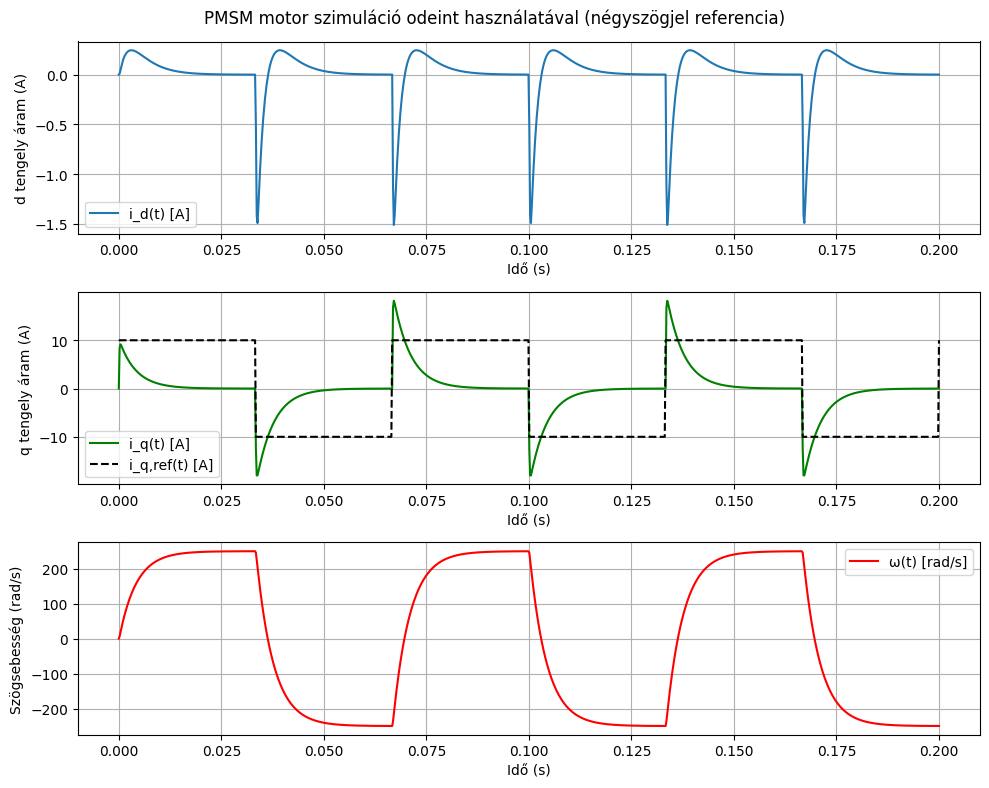

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# PMSM motor paraméterek
Rs = 0.2       # Stator ellenállás [ohm]
Ld = 0.001     # d tengely induktivitás [H]
Lq = 0.001     # q tengely induktivitás [H]
lambda_pm = 0.1  # Állandó mágneses fluxus [Wb]
J = 0.0001     # Tehetetlenségi nyomaték [kg*m^2]
B = 0.0        # Viszkózus súrlódási együttható [N*m*s/rad]
P = 4          # Póluspárok száma
T_load = 0.0   # Terhelő nyomaték [Nm]

# Négyszögjel paraméterei
iq_high = 10.0  # q tengely áram felső értéke [A]
iq_low = -10.0  # q tengely áram alsó értéke [A]
freq = 15.0      # Négyszögjel frekvenciája [Hz]

# Kezdeti állapotok: [i_d, i_q, omega_m]
x0 = [0.0, 0.0, 0.0]

# Időtartomány: 0-tól 0.2 másodpercig, 1000 pontban
t = np.linspace(0, 0.2, 1000)

# Négyszögjel generálása
def square_wave(t, freq, high, low):
    T = 1.0 / freq  # Periódusidő
    return high if (t % T) < (T / 2.0) else low

# Differenciálegyenlet rendszer
def pmsm_model(x, t):
    id, iq, omega_m = x
    omega_e = P * omega_m  # Elektromos szögsebesség

    # Négyszögjel referencia q tengelyen
    iq_ref = square_wave(t, freq, iq_high, iq_low)

    # PI szabályozó (egyszerűsített, csak P tag)
    Kp = 10.0  # P szabályozó erősítése
    Vd = -Kp * id  # d tengely feszültség (id_ref = 0)
    Vq = Kp * (iq_ref - iq)  # q tengely feszültség

    # d-q tengely egyenletek
    did_dt = (Vd - Rs * id + omega_e * Lq * iq) / Ld
    diq_dt = (Vq - Rs * iq - omega_e * Ld * id - omega_e * lambda_pm) / Lq

    # Elektromágneses nyomaték
    Te = (3/2) * P * (lambda_pm * iq + (Ld - Lq) * id * iq)

    # Mechanikai egyenlet
    domega_dt = (Te - T_load - B * omega_m) / J

    return [did_dt, diq_dt, domega_dt]

# Differenciálegyenlet megoldása
x = odeint(pmsm_model, x0, t)

# Eredmények kinyerése
id_vals = x[:, 0]
iq_vals = x[:, 1]
omega_vals = x[:, 2]

# Négyszögjel referencia áramok
iq_ref_vals = np.array([square_wave(ti, freq, iq_high, iq_low) for ti in t])

# Ábrázolás
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(t, id_vals, label="i_d(t) [A]")
plt.xlabel("Idő (s)")
plt.ylabel("d tengely áram (A)")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, iq_vals, 'g', label="i_q(t) [A]")
plt.plot(t, iq_ref_vals, 'k--', label="i_q,ref(t) [A]")
plt.xlabel("Idő (s)")
plt.ylabel("q tengely áram (A)")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, omega_vals, 'r', label="ω(t) [rad/s]")
plt.xlabel("Idő (s)")
plt.ylabel("Szögsebesség (rad/s)")
plt.grid(True)
plt.legend()

plt.suptitle("PMSM motor szimuláció odeint használatával (négyszögjel referencia)")
plt.tight_layout()
plt.show()